# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [92]:
# TODO: Install any packages that you might need
!pip install torch torchvision tqdm
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 881.9 MB 8.1 kB/s              MB 96.9 MB/s eta 0:00:01
     |████████████████████████████████| 23.3 MB 50.8 MB/s            
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████

In [93]:
# TODO: Import any packages that you might need
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import os
import smdebug
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://bucket-eastp3/ --recursive

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [72]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.01),
    "batch_size": CategoricalParameter([32, 64, 128, 256]),
}
role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [76]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='dog_classifier',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type
)
# TODO: Your HP tuner here

In [77]:
# TODO: Fit your HP Tuner
os.environ['SM_CHANNEL_TRAINING']='s3://bucket-eastp3/'
os.environ['SM_MODEL_DIR']='s3://bucket-eastp3/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://bucket-eastp3/output/'

In [78]:
tuner.fit({"training": "s3://bucket-eastp3/"}) # TODO: Remember to include your data channels

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [80]:
# TODO: Get the best estimators and the best HPs
best_estimator =tuner.best_estimator()


2021-12-28 10:52:36 Starting - Preparing the instances for training
2021-12-28 10:52:36 Downloading - Downloading input data
2021-12-28 10:52:36 Training - Training image download completed. Training in progress.
2021-12-28 10:52:36 Uploading - Uploading generated training model
2021-12-28 10:52:36 Completed - Training job completed


In [81]:
#TODO:Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.005465313064459259',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog_classifier-2021-12-28-10-05-41-086"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-378703554742/dog_classifier-2021-12-28-10-05-41-086/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [82]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=200, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [83]:
hyperparams = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}

In [84]:
# TODO: Create and fit an estimator
estimator =PyTorch(
    entry_point='train_model.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=3,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparams,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [85]:
# TODO: Your estimator here
estimator.fit({"training": "s3://bucket-eastp3/"}, wait=False)

In [ ]:
# TODO: Plot a debugging output.
https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-profiling-report.html
https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-on-studio-insights.html
https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#profiler-report

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [86]:
# TODO: Display the profiler output
estimator.output_path

's3://sagemaker-us-east-1-378703554742/'

In [87]:
estimator.latest_training_job.job_name

'dog-pytorch-2021-12-28-11-15-11-801'

In [88]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [94]:
path = estimator.latest_job_profiler_artifacts_path()
print(path)
from smdebug.profiler.system_metrics_reader import S3SystemMetricsReader
system_metrics_reader = S3SystemMetricsReader(path)
system_metrics_reader.refresh_event_file_list()
last_timestamp = system_metrics_reader.get_timestamp_of_latest_available_file()
events = system_metrics_reader.get_events(0, last_timestamp)
print("Found", len(events), "recorded system metric events. Latest recorded event:", last_timestamp)

s3://sagemaker-us-east-1-378703554742/dog-pytorch-2021-12-28-11-15-11-801/profiler-output
[2021-12-28 11:43:29.833 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-28 11:43:30.034 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO metrics_reader_base.py:134] Getting 63 event files
Found 275982 recorded system metric events. Latest recorded event: 1640691420000000


In [96]:
! aws s3 ls {rule_output_path} --recursive

2021-12-28 11:37:15     330416 dog-pytorch-2021-12-28-11-15-11-801/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-28 11:37:15     171825 dog-pytorch-2021-12-28-11-15-11-801/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-28 11:37:11        192 dog-pytorch-2021-12-28-11-15-11-801/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-28 11:37:11        201 dog-pytorch-2021-12-28-11-15-11-801/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-28 11:37:11        126 dog-pytorch-2021-12-28-11-15-11-801/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-28 11:37:11        127 dog-pytorch-2021-12-28-11-15-11-801/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-28 11:37:11        200 dog-pytorch-2021-12-28-11-15-11-801/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2021-12-28 

In [122]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-378703554742/dog-pytorch-2021-12-28-11-15-11-801/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-378703554742/dog-pytorch-2021-12-28-11-15-11-801/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-378703554742/dog-pytorch-2021-12-28-11-15-11-801/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-378703554742/dog-pytorch-2021-12-28-11-15-11-801/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-378703554742/dog-pytorch-2021-12-28

In [120]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

## Model Deploying

In [98]:
# We need first to serialise and deserilize our input image and our output later to see the result in pic.
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [99]:
# TODO: Deploy your model to an endpoint
model_location=estimator.model_data
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large') # TODO: Add your deployment configuration like instance type and number of instances


------!

In [100]:
import requests
request_dict={ "url": "https://roozaneh.net/wp-content/uploads/2018/10/aks-sag-11.jpg" }
#request_dict={ "url": "https://roozaneh.net/wp-content/uploads/2018/10/aks-sag-19-e1538579670362.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

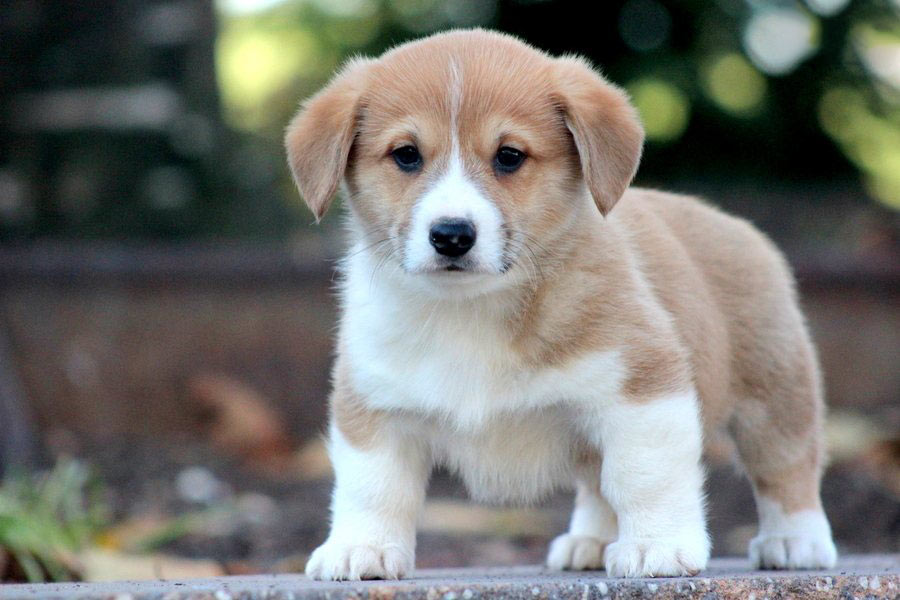

In [101]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [102]:
# TODO: Run an prediction on the endpoint
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
# TODO: Your code to load and preprocess image to send to endpoint for prediction

In [103]:
response

[[-20.289541244506836,
  -12.253302574157715,
  -11.517375946044922,
  -4.227844715118408,
  -4.842953205108643,
  -6.451539993286133,
  -8.005104064941406,
  -6.420825004577637,
  -17.876678466796875,
  -3.528643846511841,
  -9.899518966674805,
  -4.009095668792725,
  -14.130982398986816,
  -3.3275537490844727,
  -10.950848579406738,
  -6.606062412261963,
  -6.666271209716797,
  -11.343058586120605,
  -10.712754249572754,
  -16.310184478759766,
  -10.044913291931152,
  -13.116497993469238,
  -8.036510467529297,
  -8.037398338317871,
  -17.858535766601562,
  -19.14263153076172,
  -18.99797821044922,
  -16.68442153930664,
  -5.539491653442383,
  -13.187817573547363,
  -2.194746732711792,
  -8.203110694885254,
  -19.58786392211914,
  -12.600732803344727,
  -15.681071281433105,
  -16.883861541748047,
  -4.083846569061279,
  -17.724000930786133,
  -4.216355800628662,
  -8.129799842834473,
  -12.78345012664795,
  -17.93647575378418,
  -2.541900873184204,
  -13.181005477905273,
  -3.91304636

In [104]:
import numpy as np
np.argmax(response, 1)

array([94])

## 94 class is Komondor dog breed 

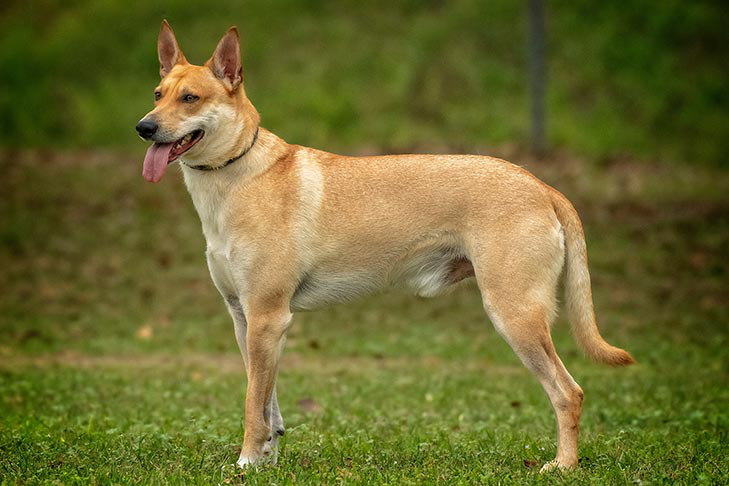

In [105]:
##https://sanjagh.pro/cdn/articles/aK3XGndFQduqG31CsqeNpA_624x416.jpg
##https://sanjagh.pro/cdn/articles/awGcZJf1SMmvJ05AHvHo0g_624x415.jpg
request_dict2={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }
img_bytes2 = requests.get(request_dict2['url']).content
import io
Image.open(io.BytesIO(img_bytes2))

In [44]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
len(response[0])
response

[[-1.2800995111465454,
  -0.5128015279769897,
  0.7272892594337463,
  3.072357654571533,
  2.8588309288024902,
  1.5415949821472168,
  2.016301155090332,
  1.352808952331543,
  0.15853866934776306,
  2.7536168098449707,
  1.7012932300567627,
  2.3233227729797363,
  -1.2143635749816895,
  1.779147744178772,
  1.6244477033615112,
  2.1028480529785156,
  -2.348984479904175,
  1.6404430866241455,
  -0.4647202491760254,
  1.5920754671096802,
  0.18883782625198364,
  1.5064506530761719,
  1.349446415901184,
  -0.4660738706588745,
  -0.8615760207176208,
  -0.8451203107833862,
  -0.3108893632888794,
  0.6733182668685913,
  2.856309652328491,
  -1.5500868558883667,
  2.888481378555298,
  2.032451868057251,
  -0.5743056535720825,
  1.233650803565979,
  -1.85539710521698,
  -0.30929943919181824,
  0.9092286229133606,
  -2.4442965984344482,
  -0.01332828775048256,
  -1.6769996881484985,
  1.0439720153808594,
  -0.5038635730743408,
  2.68760347366333,
  0.8568558096885681,
  3.2574636936187744,
  -

In [42]:
np.argmax(response[0])

117

In [60]:
max(response[0])

3.849508047103882

In [61]:
response[0].index(max(response[0]))

117

In [45]:
import json
response2=predictor.predict(json.dumps(request_dict2), initial_args={"ContentType": "application/json"})

In [46]:
type(response2[0][0])

float

In [48]:
response2

[[-1.0440715551376343,
  -0.5386025905609131,
  0.2500110864639282,
  1.7811874151229858,
  1.676490306854248,
  0.5255875587463379,
  1.3120028972625732,
  1.0403013229370117,
  0.044994160532951355,
  1.6624058485031128,
  1.3354310989379883,
  1.543928623199463,
  -1.0192298889160156,
  1.490477204322815,
  1.1467794179916382,
  1.4623888731002808,
  -2.0381176471710205,
  1.346155047416687,
  -0.6454912424087524,
  1.1452789306640625,
  0.46037328243255615,
  1.0193579196929932,
  1.084189534187317,
  -0.8313771486282349,
  -0.4034699499607086,
  -0.7707958817481995,
  -0.24996353685855865,
  0.45308205485343933,
  1.970644235610962,
  -1.2399765253067017,
  1.7330361604690552,
  1.4634063243865967,
  -0.7339465618133545,
  1.0660662651062012,
  -1.0873607397079468,
  -0.5928987860679626,
  0.6093637347221375,
  -1.9059876203536987,
  0.12379293143749237,
  -1.0793366432189941,
  0.7345854043960571,
  -0.5918178558349609,
  1.72203528881073,
  0.8063433170318604,
  2.06434416770935

In [53]:
np.argmax(response2[0])

117

In [58]:
max(response2[0])

2.3229005336761475

In [59]:
response2[0].index(max(response2[0]))

117

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()